## This Notebook is for the following paper

<p style="font-size: 12pt">Ji, Q., B. Luo, and B. Biondi (2024). Exploiting the Potential of Urban DAS Grids: Ambient-Noise Subsurface Imaging Using Joint Rayleigh and Love Waves, Seismol. Res. Lett. XX, 1–18, doi: 10.1785/0220230104</p>

## Load general python packages

In each session, the relevant packages will be loaded first. You may directly use `!pip install` to install the missing packages.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob, os
import numpy as np
from scipy import signal

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from obspy import Trace, Stream, UTCDateTime

In [3]:
%matplotlib inline
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['figure.dpi'] = 70  # Only for Notebook visualization

## Read cross-correlation data

In [4]:
# Load global parameters
from my_func.param_global import dt, tlen, Npts

# Time axis of cross-correlation function
timestamp = np.linspace(-tlen/2, tlen/2, num=Npts, endpoint=True)

In [5]:
### Read DAS channel pairs information ###
xcf_info = pd.read_csv('./channel_info/channel_info.csv', index_col=0)

In [6]:
### Directory of cross-correlation data ###
corr_path = './SJC_xcorr_data/'

# Read cross-correlation data
xcf_list = glob.glob(corr_path + '*all_hrs.npy')
xcf_list.sort(key=lambda x: int(os.path.basename(x).split('_')[2]))
xcf_list

['./SJC_xcorr_data/xcorr_ivs_0_all_hrs.npy',
 './SJC_xcorr_data/xcorr_ivs_1_all_hrs.npy',
 './SJC_xcorr_data/xcorr_ivs_2_all_hrs.npy',
 './SJC_xcorr_data/xcorr_ivs_3_all_hrs.npy',
 './SJC_xcorr_data/xcorr_ivs_4_all_hrs.npy',
 './SJC_xcorr_data/xcorr_ivs_5_all_hrs.npy',
 './SJC_xcorr_data/xcorr_ivs_6_all_hrs.npy',
 './SJC_xcorr_data/xcorr_ivs_7_all_hrs.npy',
 './SJC_xcorr_data/xcorr_ivs_8_all_hrs.npy',
 './SJC_xcorr_data/xcorr_ivs_9_all_hrs.npy',
 './SJC_xcorr_data/xcorr_ivs_10_all_hrs.npy',
 './SJC_xcorr_data/xcorr_ivs_11_all_hrs.npy',
 './SJC_xcorr_data/xcorr_ivs_12_all_hrs.npy',
 './SJC_xcorr_data/xcorr_ivs_13_all_hrs.npy',
 './SJC_xcorr_data/xcorr_ivs_14_all_hrs.npy',
 './SJC_xcorr_data/xcorr_ivs_15_all_hrs.npy',
 './SJC_xcorr_data/xcorr_ivs_16_all_hrs.npy',
 './SJC_xcorr_data/xcorr_ivs_17_all_hrs.npy',
 './SJC_xcorr_data/xcorr_ivs_18_all_hrs.npy',
 './SJC_xcorr_data/xcorr_ivs_19_all_hrs.npy',
 './SJC_xcorr_data/xcorr_ivs_20_all_hrs.npy',
 './SJC_xcorr_data/xcorr_ivs_21_all_hrs.npy'

## Plot channel pair properties

In [10]:
from my_func.plot_xcf import plot_channel_info

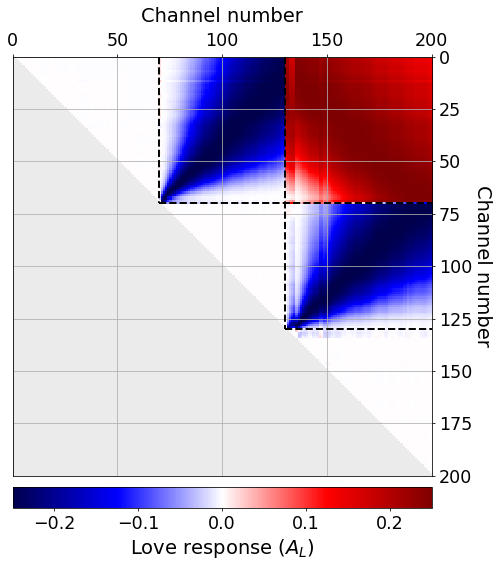

In [16]:
# 1: Distance          (Figure 3a)
# 2: Rayleigh response (Figure 3b)
# 3: Love response     (Figure 3c)

### Specific variable to plot ###
var_index = 3

# Plot channel pair property
fig, ax = plot_channel_info(xcf_info, var_index)

## Plot DAS cross-correlation profiles

In [17]:
from my_func.param_profiles import get_param_profile
from my_func.preprocess import select_correlations, bpfilter
from my_func.plot_xcf import plot_two_profiles, plot_profile

In [18]:
# Case 1 (Figure 4): Inline  + Parallel
# Case 2 (Figure 5): Oblique + Parallel
# Case 3 (Figure 6): Oblique + Parallel
# Case 4           : Inline  + Inline (for Rayleigh wave measurements)

### Specific case to plot ###
case = 1

### Bandpass filter ###
filter_range = [0.5, 10]


# Parameters for selecting profiles
param_profile = get_param_profile(xcf_info, case)

# Channel pairs information
ind_pair1 = xcf_info[param_profile['mask1']]
ind_pair1 = ind_pair1.sort_values(**param_profile['sort1'])
ind_pair2 = xcf_info[param_profile['mask2']]
ind_pair2 = ind_pair2.sort_values(**param_profile['sort2'])

# Juxtaposed profiles
gather1 = select_correlations(ind_pair1, xcf_list)
gather2 = select_correlations(ind_pair2, xcf_list)

# Bandpass filter
gather1 = bpfilter(gather1, filter_range[0], filter_range[1])
gather2 = bpfilter(gather2, filter_range[0], filter_range[1])

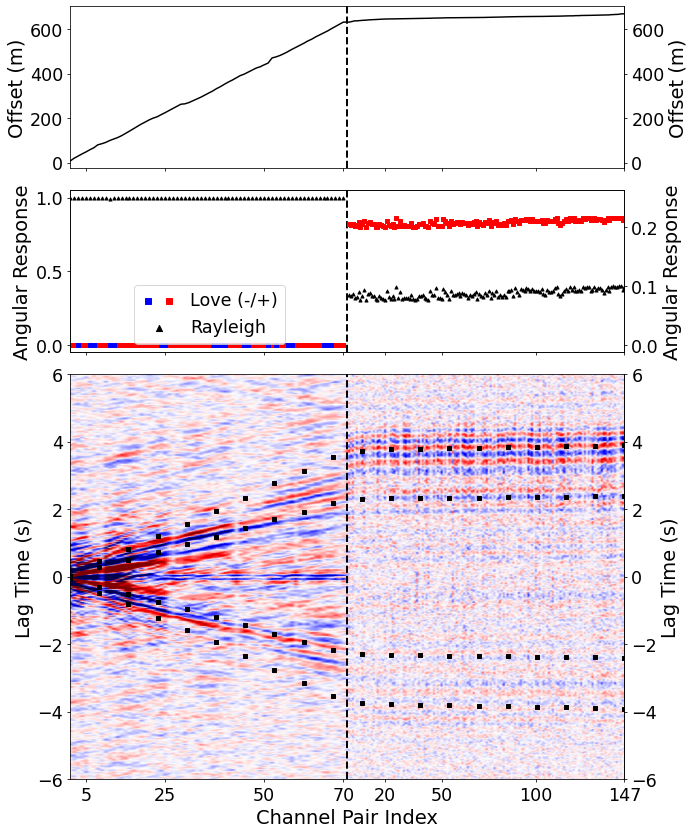

In [19]:
# Plot juxtaposed profiles
# Argument 'kind' can be either 'profile' (panel d) or 'envelope' (panel e)

plot_two_profiles(ind_pair1, ind_pair2, gather1, gather2, kind='profile', case=case)

## Love / Rayleigh ratio ($A_L/A_R$)

In [20]:
from my_func.preprocess import get_amps
from my_func.plot_xcf import plot_amp_ratio

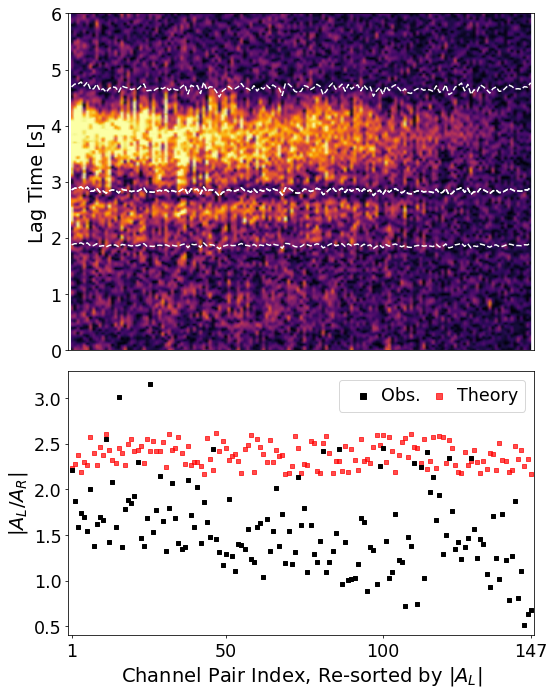

In [21]:
# Case 1,      Parallel: Figure 8a, 8c
# Case 2 or 3, Parallel: Figure 8b, 8d

if case in [1, 2, 3]:
    plot_amp_ratio(gather2, ind_pair2, case=case)

## Create dispersion map

In [22]:
from my_func.preprocess import window_trace
from my_func.param_dispmaps import get_window_params, get_disp_profile
from my_func.dispersion import get_ave_vph_map, plot_dispmap
from my_func.dispersion import stack_psd, stack_psd_correction
from my_func.dispersion import get_dispcurve, plot_dispcurve

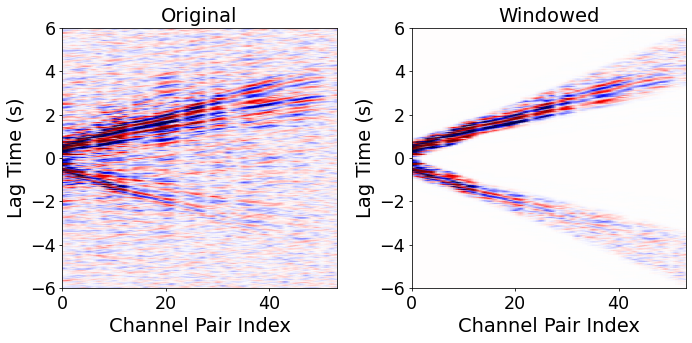

In [23]:
# Disp_case 1 (Figure 9a): Love, Group
# Disp_case 2 (Figure 9b): Love, Phase
# Disp_case 3 (Figure 9c): Rayleigh, Phase, Fundamental
# Disp_case 4 (Figure 9d): Rayleigh, Phase, 1st Overtone

### Specific dispersion curve to measure ###
disp_case = 2


# Obtain corresponding profile
ind_pair, gather = get_disp_profile(xcf_info, xcf_list, index=disp_case)

# Channel pair offsets
offset = ind_pair['Distance'].to_numpy()

# No windowing for group velocity measurement
if disp_case == 1:
    win_params = None
    win_gather = gather
    
    # Order by Love amplitude (AL)
    amp_L, _ = get_amps(gather, ind_pair)
    order_L = np.flip(np.argsort(amp_L))
    ind_pair, win_gather = ind_pair.iloc[order_L, :], win_gather[order_L, :]
    offset = ind_pair['Distance'].to_numpy()

# Apply window to phase velocity measurement
elif disp_case == 2:
           
    # Remove traces with very small offsets
    # (To be exactly same with Figure 9b. However, not doing it is fine and does not influence)
    min_i = 5
    ind_pair, gather = ind_pair.iloc[min_i:, :], gather[min_i:, :]
    offset = ind_pair['Distance'].to_numpy()
    
    win_params = get_window_params('L')
    win_gather = window_trace(gather, offset, **win_params)
    
elif disp_case in [3, 4]:
    win_params = get_window_params('R')
    win_gather = window_trace(gather, offset, **win_params)
    
# Plot original & windowed profiles
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0] = plot_profile(gather, ax=axes[0])
axes[1] = plot_profile(win_gather, ax=axes[1])
axes[0].set_title('Original')
if disp_case == 1:
    axes[1].set_title('Re-sorted by $|A_L|$')
else:
    axes[1].set_title('Windowed')
plt.tight_layout(w_pad=2)

In [24]:
# Obtain group velocity dispersion map
if disp_case == 1:
    
    # Select top 75% traces (111 traces for Case 1, Parallel)
    max_i = np.ceil(0.75*ind_pair.shape[0]).astype(int)
    
    # Frequency & Group velocity samples
    _vg_freqs = np.arange(filter_range[0], filter_range[1]+0.01, 0.02)
    vg_vels = np.arange(100., 701., 1.)
    
    # Group dispersion map (only positive branch selected)
    # Figure 9a shows the map before instantaneous frequency correction (smoother for visualization)
    vg_freqs, cwt_map, _, coi, _ = stack_psd(win_gather[:max_i, :], ind_pair.iloc[:max_i, :], 
                                             timestamp, vg_vels, filter_range, _vg_freqs.shape[0])
    
    # Group dispersion curve for inversion (Figure 10a) is after correction
    # vg_freqs, cwt_map, _, coi, _ = stack_psd_correction(win_gather[:max_i, :], ind_pair.iloc[:max_i, :], 
    #                                                     timestamp, vg_vels, filter_range, _vg_freqs.shape[0])

# Obtain phase velocity dispersion map
elif disp_case in [2, 3, 4]:
    
    # Frequency & Phase velocity samples
    vph_freqs = np.arange(filter_range[0], filter_range[1]+0.01, 0.02)
    vph_vels = np.arange(100., 701., 1.)
    
    # Phase dispersion map (averaged over two branches)
    fv_map = get_ave_vph_map(win_gather, offset, vph_freqs, vph_vels, dt=dt)

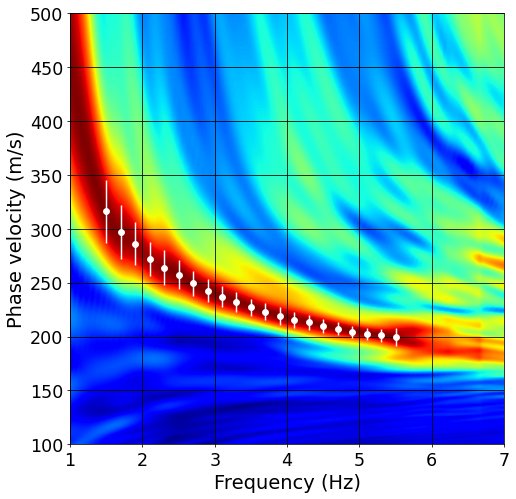

In [25]:
# Plot group velocity dispersion
if disp_case == 1:
    fig, ax = plot_dispmap(cwt_map, extent=[vg_freqs[0], vg_freqs[-1], vg_vels[0], vg_vels[-1]], 
                           vel_type='group')
    
    # Measure group velocity dispersion curve
    dispcurve = get_dispcurve(vg_freqs, vg_vels, cwt_map, disp_case)
    plot_dispcurve(dispcurve, vel_type='group', ax=ax, fmt='o', color='w')
    
# Plot phase velocity dispersion
elif disp_case in [2, 3, 4]:
    fig, ax = plot_dispmap(fv_map, extent=[vph_freqs[0], vph_freqs[-1], vph_vels[0], vph_vels[-1]])
    
    # Measure phase velocity dispersion curve
    dispcurve = get_dispcurve(vph_freqs, vph_vels, fv_map, disp_case)
    plot_dispcurve(dispcurve, ax=ax, fmt='o', color='w')

In [133]:
# Save data

# Phase velocity dispersion map
# np.savez('./disp_maps/love_phase_0.npz', freqs=vph_freqs, vels=vph_vels, fv_map=fv_map)
# np.savez('./disp_maps/rayleigh_phase_0.npz', freqs=vph_freqs, vels=vph_vels, fv_map=fv_map)
# np.savez('./disp_maps/rayleigh_phase_1.npz', freqs=vph_freqs, vels=vph_vels, fv_map=fv_map)

# Group velocity dispersion map
# np.savez('./disp_maps/love_group_0.npz', freqs=vg_freqs, vels=vg_vels, cwt_map=cwt_map)
# np.savez('./disp_maps/love_group_0_correction.npz', freqs=vg_freqs, vels=vg_vels, cwt_map=cwt_map)

## Inversion of S-wave velocity

This part uses the following python package (version 2.0.1): 

Luu, K. (2021). evodcinv: Inversion of dispersion curves using evolutionary algorithms, doi: 10.5281/zenodo.5785565.

Github page: https://github.com/keurfonluu/evodcinv/tree/v2.0.1

Reference: Luu, K., M. Noble, A. Gesret, N. Belayouni, and P.-F. Roux (2018). A parallel competitive Particle Swarm Optimization for non-linear first arrival travel time tomography and uncertainty quantification, Comput. Geosci. 113, 81–93.

In [ ]:
# Install package
#!pip install evodcinv --user
#!pip install disba joblib

In [166]:
import evodcinv
print(evodcinv.__version__)

2.0.1


In [203]:
# Vs model from Hayashi & Burns (2020)
# Units: m and m/s
hayashi_model = {'Depth':np.array([0, 10.0, 10.0, 37.2, 37.2, 81.1, 81.1, 270.3, 270.3, 1000]), \
                 'Vs':np.array([88.9, 88.9, 233.3, 233.3, 322.2, 322.2, 588.9, 588.9, 900, 900])}

Hayashi, K., and S. Burns (2020). Three-dimensional deep S-wave velocity model of the South San Francisco Bay Area obtained from three-component microtremor measurements and microtremor array measurements, in SEG Technical Program Expanded Abstracts 2020, Society of Exploration Geophysicists, 3427–3431.

In [207]:
from evodcinv import EarthModel, Layer, Curve
from my_func.inversion import read_curves_from_dispmap
from my_func.inversion import plot_curve, plot_model_range, plot_models, plot_predicted_curve

from matplotlib.colors import ListedColormap
from matplotlib import cm

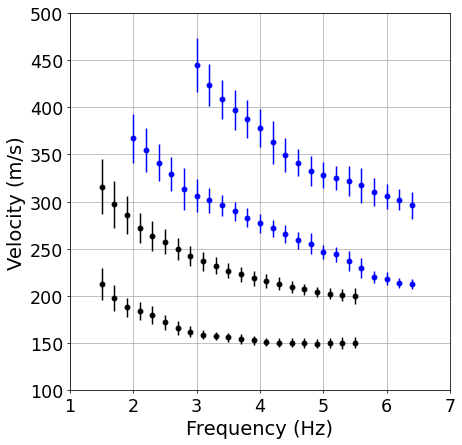

In [199]:
# Read all dispersion curves from dispersion maps
curves = read_curves_from_dispmap(dir_dispmap='./disp_maps/')

# Plot dispersion curves
fig, ax = plt.subplots(figsize=(7, 7))
for curve, color in zip(curves, ['k', 'k', 'b', 'b']):
    ax = plot_curve(curve, ax=ax, color=color)
ax.grid('gray')

In [201]:
### Inversion Setup ###

# Initialize model
model = EarthModel()

# Build model search boundaries from top to bottom
# First argument is the bounds of layer's thickness [km]
# Second argument is the bounds of layer's S-wave velocity [km/s]
# Third argument is the bounds of layer's Poisson ratio (default: 0.2-0.4)

model.add(Layer([0.005, 0.015], [0.05, 0.3], [0.492, 0.492]))
model.add(Layer([0.005, 0.025], [0.05, 0.5], [0.492, 0.492]))
model.add(Layer([0.02, 0.06], [0.2, 0.8], [0.485, 0.485]))
model.add(Layer([0.02, 0.1], [0.4, 1.0], [0.45, 0.45]))

# Density model (Nagashima & Kawase, 2021)
f_rho = lambda x: 1.56 + 0.186*x

# Configure model
model.configure(
    optimizer = "cpso",  # Evolutionary algorithm
    misfit = "norm2",    # Misfit function type (default: rmse)
    density = f_rho,     # Density model (default: nafe-drake)
    optimizer_args = {
        "popsize": 50,   # Population size
        "maxiter": 1000, # Number of iterations
        "workers": -1,   # Number of cores    
        "seed": None,    # Random seed (robust with different seeds for sufficient runs)
    },
)

In [202]:
### Run inversion ###
res = model.invert(curves, maxrun=5)  # maxrun: Number of independent runs
print(res)

Run 1   |████████████████████| 100% [0:00:51 / 0:00:00] - Misfit: 6.6966  
Run 2   |████████████████████| 100% [0:00:40 / 0:00:00] - Misfit: 6.7064  
Run 3   |████████████████████| 100% [0:00:40 / 0:00:00] - Misfit: 6.6993  
Run 4   |████████████████████| 100% [0:00:40 / 0:00:00] - Misfit: 6.7060  
Run 5   |████████████████████| 100% [0:00:40 / 0:00:00] - Misfit: 6.7186  
Run 6   |████████████████████| 100% [0:00:41 / 0:00:00] - Misfit: 6.7317  
Run 7   |████████████████████| 100% [0:00:40 / 0:00:00] - Misfit: 6.6989  
Run 8   |████████████████████| 100% [0:00:47 / 0:00:00] - Misfit: 7.2711  
Run 9   |████████████████████| 100% [0:00:47 / 0:00:00] - Misfit: 6.7192  
Run 10  |████████████████████| 100% [0:00:49 / 0:00:00] - Misfit: 7.2533  
Run 11  |████████████████████| 100% [0:00:46 / 0:00:00] - Misfit: 6.6942  
Run 12  |████████████████████| 100% [0:00:45 / 0:00:00] - Misfit: 6.6908  
Run 13  |████████████████████| 100% [0:00:45 / 0:00:00] - Misfit: 6.7140  
Run 14  |████████████████

--------------------------------------------------------------------------------
Best model out of 1000000 models (20 runs)

Velocity model                                    Model parameters
----------------------------------------          ------------------------------
         d        vp        vs       rho                   d        vs        nu
      [km]    [km/s]    [km/s]   [g/cm3]                [km]    [km/s]       [-]
----------------------------------------          ------------------------------
    0.0085    1.2569    0.1577    1.7938              0.0085    0.1577    0.4920
    0.0108    1.7705    0.2222    1.8893              0.0108    0.2222    0.4920
    0.0415    1.8732    0.3197    1.9084              0.0415    0.3197    0.4850
    1.0000    1.5838    0.4775    1.8546                   -    0.4775    0.4500
----------------------------------------          ------------------------------

Number of layers: 4
Number of parameters: 11
Best model misfit: 6.6908
-------

In [208]:
# Remove infinite misfit values (to max misfit)
mask = np.isfinite(res.misfits)
res.misfits[~mask] = res.misfits[mask].max()
res.misfits = np.log10(res.misfits)

# Colormap
cmap = cm.get_cmap('gray')
cmap = ListedColormap(cmap(np.linspace(0, 0.9, 256)))

Plot 10000 models.
Plot mean of 300001 models.
Misfit range: 0.8255, 0.8612.


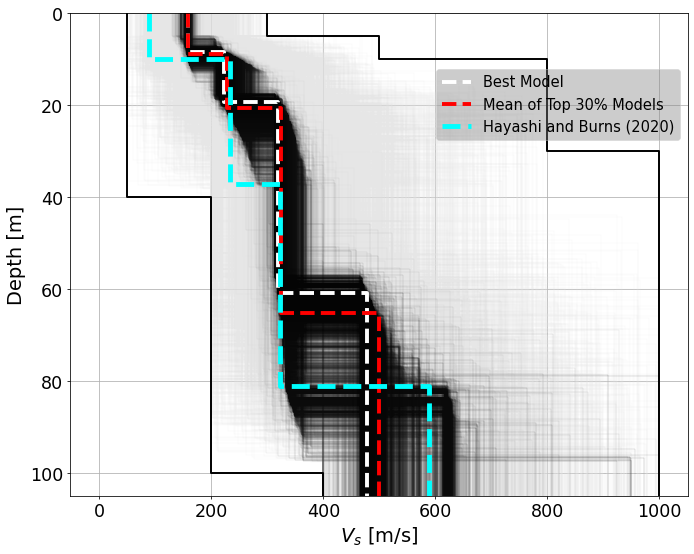

In [211]:
### Plot inversion results ###

# Plotting parameters
param = 'vs'           # vs, vp or rho
show = 'percentage'    # percentage, best or mean
percent = 100
stride = 100           # plot one model every 'stride'
cmap_range = (0.8, 2)

# Inversion results
fig, ax = plt.subplots(figsize=(10, 8))
plot_models(res, param, show=show, stride=stride, percent=percent, 
            plot_args={"cmap":cmap, "linewidth":0.15}, ax=ax, 
            cmap_on=False, cmap_args={"label":"Log L2-Misfit"}, cmap_range=cmap_range)

# Best & Mean models
plot_models(res, param, show='best', plot_args={"color":"white", "linewidth":4, "linestyle":"--"})
plot_models(res, param, show='mean', percent=30, plot_args={"color":"red", "linewidth":4, "linestyle":"--"})

# Model parameter range
plot_model_range(model, ax=ax)

# Vs model from Hayashi & Burns (2020)
obj3, = ax.plot(hayashi_model['Vs'], hayashi_model['Depth'], linestyle='--', color='cyan', 
                linewidth=5, alpha=1, label='Hayashi and Burns (2020)')

# Legend
obj1, = ax.plot([-1, -2], [-1, -2], 'w--', linewidth=4, label='Best Model')
obj2, = ax.plot([-1, -2], [-1, -2], 'r--', linewidth=4, label='Mean of Top 30% Models')
ax.legend(handles=[obj1, obj2, obj3], fontsize=15, facecolor='gray', framealpha=0.4, 
          loc='upper right', bbox_to_anchor=(1, 0.9))

ax.set_ylim([105, 0])
ax.grid()
plt.tight_layout(pad=1.0)

Plot curves from 151 models.
Plot curves from 151 models.
Plot curves from 151 models.
Plot curves from 151 models.


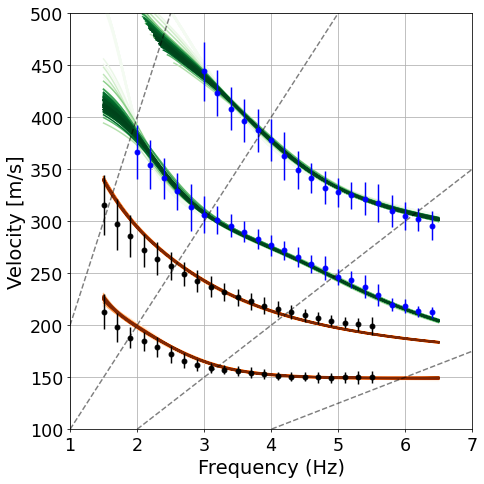

In [214]:
### Plot predicted dispersion curves ###

# Plotting parameters
show = 'percentage'    # percentage or best
percent = 30
stride = 2000          # plot one model every 'stride'

# Plot predicted dispersion curves
fig, ax = plt.subplots(figsize=(7, 7))
plot_predicted_curve(res, np.linspace(1/6.5, 1/1.5, 100), 0, 'love', 'phase', show=show, percent=percent, 
                     ax=ax, stride=stride, plot_args={"xaxis": "frequency"})
plot_predicted_curve(res, np.linspace(1/6.5, 1/1.5, 100), 0, 'love', 'group', show=show, percent=percent, 
                     ax=ax, stride=stride, plot_args={"xaxis": "frequency"})
plot_predicted_curve(res, np.linspace(1/6.5, 1/1.5, 100), 0, 'rayleigh', 'phase', show=show, percent=percent, 
                     ax=ax, stride=stride, plot_args={"xaxis": "frequency", "cmap":'Greens_r'})
plot_predicted_curve(res, np.linspace(1/6.5, 1/1.5, 100), 1, 'rayleigh', 'phase', show=show, percent=percent, 
                     ax=ax, stride=stride, plot_args={"xaxis": "frequency", "cmap":'Greens_r'})

# Plot measured dispersion curves
for curve, color in zip(curves, ['k', 'k', 'b', 'b']):
    plot_curve(curve, ax=ax, color=color)

# Plot reference wavelength
f_samp = np.linspace(1, 7, 100)
for wavelength in [25, 50, 100, 200]:
    ax.plot(f_samp, wavelength*f_samp, linestyle='--', color='k', alpha=0.5)
    
ax.set_ylabel('Velocity [m/s]')
ax.set_xlim([1, 7.0])
ax.set_ylim([100, 500])
ax.grid()
plt.tight_layout(pad=1.0)